# Spam Detection With LSTM - Polish Language

Author: **Marcin Sikorski**<br>
Date: September, 2023

**Introduction and Motivation**<br>
Email spam (junk mail or spam) are all sorts of unwanted, useless, creepy, or sometimes dangerous mailbox messages (phishing for example). Nowadays, most emailing services and domains use spam filters, which detect unsolicited, unwanted and virus-infected emails and prevent those messages from getting to a users inbox. These programs and algorithms are getting much more accurate and sophisticated with time. Spam detection is a typical binary classification problem.

The main motive behind this notebook is to perform a classification task on string variables: email descriptions. We will develop a LSTM (Long Short Term Memory) neural network. The input data will carry word embeddings generated with word2vec. The dataset used in this task contains advertisements from the real estate category with a binary spam flag indicating if the message is spam (1), or non-spam (0). The emails are written in Polish which means that the classifier will need an individual, pre-trained model to create embeddings.

**Table of Contents:**<br>
1. Data Loading and Text Processing
2. Exploratory Data Analysis
3. Splitting Data
4. LSTM
5. Evaluating Model Performance
6. Conclusions

### 1. Data Loading and Text Processing

The dataset for this task is a CSV file. We will drop unnecessary columns and search for null values. Then, we will perform basic description cleaning.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# import data and create dataframe
def load_dataset():
    file_name = 'spam_training_data.csv'
    df = pd.read_csv(file_name, header=0, encoding='utf-8', sep=';')
    
    # removing duplicated rows
    df = df.drop_duplicates()
    
    # drop last useless column
    df = df.iloc[:, :-1]
    return df

df = load_dataset()
df.head()

,ID,TITLE,DESCRIPTION,PRICE,SPAM_FLAG
0,43925,Pracownia plastyczna 'artystart'/Fundacja Serd...,"FUNDACJA SERDECZNIK zaprasza dzieci, młodzie...",50,1
1,67238,Owczarki Niemieckie Długowłose-OGROMNE- Owczar...,"Szczenięta tylko i wyłącznie rodowodowe: FCI ,...",3500,1
2,93863,Tusz (Kardridż) HP 41,Oryginalny kardridż firmy HP 41. Zapakowany w ...,5,1
3,126634,Zespół muzyczny ODLOT,. Zapewniamy profesjonalną oprawę muzyczną na ...,2500,1
4,169161,Super kultowa książka Moja dziewczyna,"Sprzedam lub zamienię (na kosmetyki, biżuteri...",5,1


Useless columns will be dropped. We are interested in the email descriptions and their assigned classes. At this stage we will also check for null values and display results in tabular form.

In [2]:
# save columns
df = df.loc[:, ['DESCRIPTION', 'SPAM_FLAG']]

# display data type and count null values for each column
def columns_summary():
    print('Number of emails: {}'.format(df.shape[0]))
    
    # empty lists
    col_list = df.columns.to_list()
    null_list = []
    
    for col in df.columns:
        null_list.append(df[col].isnull().sum())
    
    # stack lists into dataframe
    df_sum = pd.DataFrame(list(zip(col_list, null_list)), columns = ['Feature', 'Null values'])
    
    return df_sum.style.hide_index()
    
columns_summary()

Number of emails: 9549


Feature,Null values
DESCRIPTION,0
SPAM_FLAG,0


**Stop Words**

Polish stop words will be imported into the notebook as a list object from an URL address.

In [3]:
# load and read Polish stopwords from URL into list
def load_stopwords():
    import requests
    
    # extract stopwords
    target_url = 'https://raw.githubusercontent.com/bieli/stopwords/master/polish.stopwords.txt'
    response = requests.get(target_url)
    data = response.text
    
    # remove last signs
    str_data = data[:-1]
    
    # convert string into list
    def convert_str(string):
        lst = list(string.split('\n'))
        return lst
    
    return convert_str(str_data)

stopwords_pl = load_stopwords()

# check - show first N words
stopwords_pl[:10]

['a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ']

**Text Cleaning**

We will provide some text cleaning operations on the <code>DESCRIPTION</code> column. This should make our further work easier and improve the learning stage.

In [4]:
# text operations on descriptions
def clean_descriptions(text):
    import re
    
    string = text.lower() # set all characters into lower case
    string = re.sub(r'http\S+', '', string) # remove any HTTPS links
    string = re.sub('\n', '', string) # remove new lines
    string = re.sub(r'[^\w\s]', ' ', string) # remove punctuation (leave a space)
    string = ' '.join([word for word in string.split() if word not in (stopwords_pl)]) # remove stop words
    
    return string

df['DESCRIPTION_NEW'] = df['DESCRIPTION'].apply(lambda x: clean_descriptions(x))

# compare reviews
df.loc[:, ['DESCRIPTION', 'DESCRIPTION_NEW']].head(10)

,DESCRIPTION,DESCRIPTION_NEW
0,"FUNDACJA SERDECZNIK zaprasza dzieci, młodzie...",fundacja serdecznik zaprasza dzieci młodzież s...
1,"Szczenięta tylko i wyłącznie rodowodowe: FCI ,...",szczenięta wyłącznie rodowodowe fci zkwp najwa...
2,Oryginalny kardridż firmy HP 41. Zapakowany w ...,oryginalny kardridż firmy hp 41 zapakowany pud...
3,. Zapewniamy profesjonalną oprawę muzyczną na ...,zapewniamy profesjonalną oprawę muzyczną wszel...
4,"Sprzedam lub zamienię (na kosmetyki, biżuteri...",sprzedam zamienię kosmetyki biżuterię torebkę ...
5,"Mam do sprzedania śliczną, bardzo seksowną,cza...",sprzedania śliczną seksowną czarną sukienkę de...
6,Prezentacja wideo Naszego obiektu z drona: htt...,prezentacja wideo obiektu drona proponujemy pa...
7,jak nowe jasne kappahl kekko wycierane biodrów...,nowe jasne kappahl kekko wycierane biodrówki p...
8,"Suknia Ślubna rozmiar 36, wzrost 162-170 cm. G...",suknia ślubna rozmiar 36 wzrost 162 170 cm gor...
9,"markowe pianino E.u.M.SEILER,BERLIN-piękny dżw...",markowe pianino e m seiler berlin piękny dżwię...


### 2. Exploratory Data Analysis

The dataset is clean and ready for further investigation. We will check the class distribution, email length distribution, plot word clouds, and display trigrams.

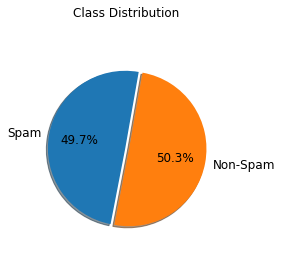

In [5]:
# check target distribution
def plot_pie_chart():
    labels = ['Spam', 'Non-Spam']
    sizes = [df['SPAM_FLAG'].value_counts()[1], df['SPAM_FLAG'].value_counts()[0]]
    
    plt.figure(figsize=(4, 4))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', explode=(0, 0.05),
            shadow=True, startangle=80, textprops={'fontsize': 12})
    plt.title('Class Distribution')
    
    # set equal aspect ratio - draw a circle
    plt.axis('equal')
    plt.tight_layout()
    plt.show()
    
plot_pie_chart()

The target distribution is balanced. No adjustments or class weights will be provided.

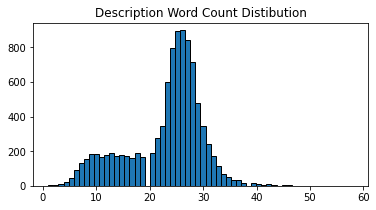

In [6]:
# plot frequency of words in description
def review_word_count(var=df['DESCRIPTION_NEW']):
    plt.figure(figsize=(6, 3))
    plt.hist(x=var.str.split().str.len(), bins=60, edgecolor='black')
    plt.title('Description Word Count Distibution')
    plt.show()
    
review_word_count()

Most numerous are emails with words between 25 and 30 counts.

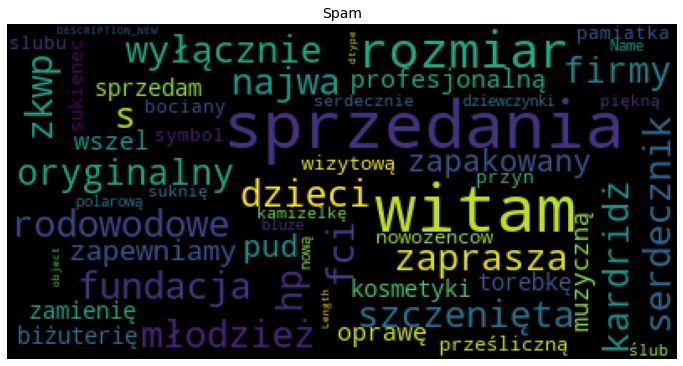

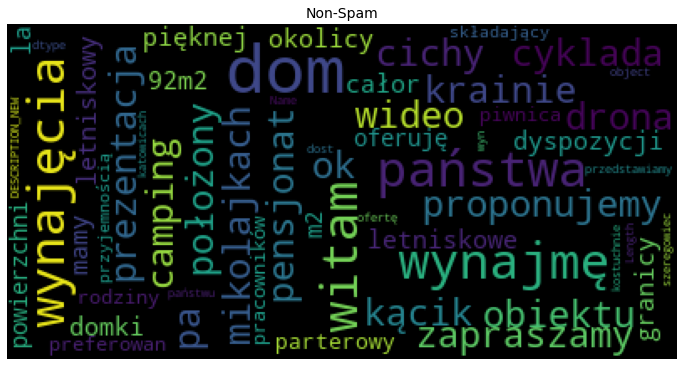

In [7]:
# plot word clouds
def plot_wordcloud(spam_flag=1, var='DESCRIPTION_NEW'):
    from wordcloud import WordCloud
    
    # filter out by 'spam'
    text = df[df['SPAM_FLAG'] == spam_flag][var]

    # generate a word cloud
    word_cloud = WordCloud(max_words=500, colormap='viridis', prefer_horizontal=0.7, max_font_size=40,
                           stopwords=stopwords_pl).generate(str(text))

    plt.figure(figsize=(12, 8))
    plt.imshow(word_cloud)
    if spam_flag:
        plt.title('Spam', size=14)
    else:
        plt.title('Non-Spam', size=14)
    plt.axis('off')
    plt.show()
    
plot_wordcloud(spam_flag=1)
plot_wordcloud(spam_flag=0)

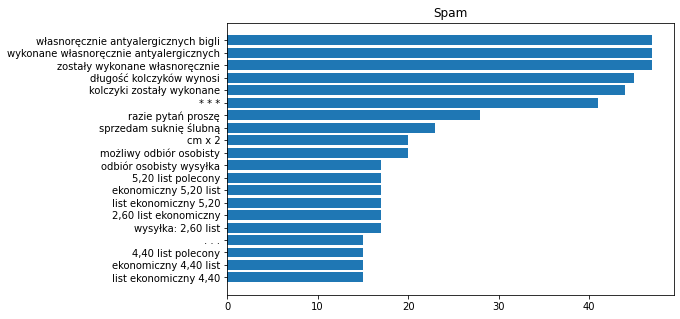

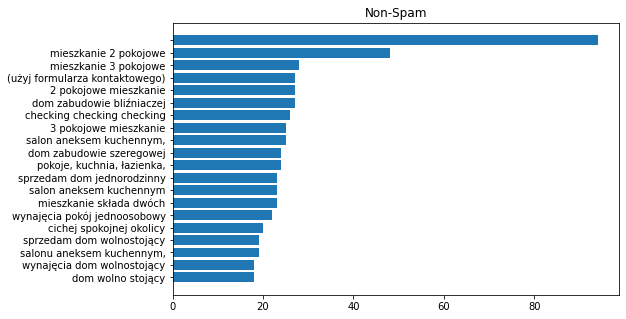

In [8]:
# plot trigrams
def plot_ngram(n=3, spam_flag=1, var='DESCRIPTION'):
    # filter out by 'spam'
    df_fil = df[df['SPAM_FLAG'] == spam_flag][var]
    
    def generate_ngrams(text, n_gram=1):
        token = [token for token in text.lower().split(' ') if token != '' if token not in stopwords_pl]
        n_grams = zip(*[token[i:] for i in range(n_gram)])
        return [' '.join(n_gram) for n_gram in n_grams]
    
    # unigram
    from collections import defaultdict
    
    freq_dict = defaultdict(int)
    for sent in df_fil:
        for word in generate_ngrams(sent, n):
            freq_dict[word] += 1
    df_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
    df_sorted.columns = ['phrase', 'frequency']
    df_sorted = df_sorted.head(20)
    
    # plot results
    plt.figure(figsize=(8, 5))
    plt.barh(df_sorted['phrase'], df_sorted['frequency'])
    plt.gca().invert_yaxis()
    if spam_flag == 1:
        plt.title('Spam')
    else:
        plt.title('Non-Spam')
    plt.show()

plot_ngram(n=3, spam_flag=1)
plot_ngram(n=3, spam_flag=0)

Non-spam emails are in general real estate advertisements. Based on the word cloud, spam descriptions contain more words related to positive emotions and cuteness: dzieci, szczenięta, piękna, młodzież, etc. They are also more related to local classifieds for selling or exchanging goods - sprzedam, zamienię, witam, oryginalny, odbiór osobisty, rodowodowe - to be just a few.

### 3. Splitting Data

We will split our string variable into training, testing, and validation data with 60:20:20 ratio. Next, we will proceed further for creating word embeddings.

In [9]:
# split data into ratios: 60/20/20
def split_data(var='DESCRIPTION_NEW'):
    from sklearn.model_selection import train_test_split

    # feature array X and target vector y
    X = df[var]
    y = df['SPAM_FLAG']

    # split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

    # split into train and validation from recent train set (batch)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size=0.8, random_state=42)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

X_train, X_test, X_val, y_train, y_test, y_val = split_data()

# check sample sizes
print('Train data:', len(X_train))
print('Test data:', len(X_test))
print('Validation data:', len(X_val))

Train data: 6111
Test data: 1910
Validation data: 1528


### 4. LSTM

For spam detecting we will implement a LSTM (Long Short Term Memory) algorithm. This type of recurrent neural network is an effective and popular tool for text classification. The major advance of using LSTM in natural language processing is the ability of using multiple word strings to find out the class to which it belongs. Non-neural network techniques usually classify every single word into one of the categories. The LSTM uses embedding layers to find out the actual meaning in input string and will give the most accurate output class.

**Word Embeddings & Tokenization**

To produce word embeddings we will implement word2vec technique. This type of NLP uses models (neural networks) to learn word associations from a large corpus of text. We will download and use a pre-trained model developed by the National Corpus of Polish (NKJP) and the Polish Academy of Science (PAN) - [website](http://dsmodels.nlp.ipipan.waw.pl/). To read the model format, we will use the <code>gensim</code> library.

Our chosen model for the task will feature:
* a NKJP + Wikipedia corpus,
* model based on lemmata,
* subtype model with parts of speech,
* 100 sized vector,
* skip-gram neural network architecture,
* softmax algorithm.

In [10]:
# extract model from zipped file
def gz_extract(directory):
    import os, gzip, shutil
    
    # loop through items in directory for GZ files
    try:
        for item in os.listdir(directory):
            if item.endswith('.gz'):
                gz_file = os.path.abspath(item) # get full path to file
                file_name = (os.path.basename(gz_file)).rsplit('.', 1)[0] # get file name
                
                with gzip.open(gz_file, 'rb') as file_in, open(file_name, 'wb') as file_out:
                    shutil.copyfileobj(file_in, file_out)
                #os.remove(gz_name) # optionally remove GZ file      
        print('File extracted')
    except:
        print('No such file')

dir_name = r'C:/Users/Marcin/notebooks/spam_polish'
gz_extract(dir_name)

File extracted


In [11]:
#pip install gensim

# load and read embeddings matrix from TXT file
def load_embeddings_matrix():
    from gensim.models.keyedvectors import load_word2vec_format

    w2v_model = load_word2vec_format(fname='nkjp+wiki-lemmas-all-100-skipg-hs.txt', binary=False, encoding='utf8')
    
    # raw vectors array of words
    return w2v_model.vectors

embedd_matrix = load_embeddings_matrix()
print('Size of embedding matrix: ', embedd_matrix.shape)

Size of embedding matrix:  (1549322, 100)


The embedding matrix contains 1549322 words. Each word (embedding sample) is a separate 100 sized vector.

In [12]:
# display embedding sample
embedd_matrix[15]

array([ 0.10578 , -0.041116, -0.001884,  0.011644,  0.400855,  0.314563,
        0.366194, -0.083629, -0.165406, -0.095909,  0.144954,  0.001249,
       -0.09711 ,  0.227154,  0.032946,  0.288341,  0.40444 ,  0.106048,
        0.220011,  0.007767,  0.082761, -0.352007,  0.144016,  0.131154,
        0.301384,  0.188635,  0.161757,  0.072215, -0.065232, -0.268393,
       -0.058051,  0.092657, -0.1376  ,  0.33253 ,  0.307865,  0.10692 ,
       -0.132502,  0.195363, -0.300417, -0.086604, -0.209599, -0.081098,
        0.058276, -0.06216 ,  0.507357,  0.084097, -0.18403 , -0.229078,
       -0.001026, -0.146945,  0.161406, -0.1071  , -0.019256, -0.450006,
       -0.183493,  0.036366,  0.208091, -0.143966, -0.142092, -0.03421 ,
        0.296416,  0.357229, -0.215854,  0.193366, -0.009911, -0.068933,
        0.048032,  0.118086,  0.094428, -0.25909 , -0.277438, -0.239471,
        0.111914,  0.131885, -0.371836, -0.196532,  0.112545,  0.334524,
        0.197287,  0.025297,  0.483748, -0.175989, 

The emails need to be tokenized and transformed into sequences. We will set the maximum pad lengths of new sequences to 100. Finally, the sequences will be converted to binary class matrices.

In [13]:
# tokenize and transform text corpus into sequences
def tokenize_data():
    from keras.preprocessing.text import Tokenizer
    
    # the maximum number of words to use - based on word frequency
    nb_words = embedd_matrix.shape[0]
    
    # initialize tokenizer & create the vocabulary index based on word frequency
    tokenizer = Tokenizer(num_words=nb_words)
    tokenizer.fit_on_texts(X_train)
    
    # transform into sequences
    sequence_train = tokenizer.texts_to_sequences(X_train)
    sequence_test = tokenizer.texts_to_sequences(X_test)
    sequence_val = tokenizer.texts_to_sequences(X_val)
    
    # additionally: set word index as a dictionary
    word_index = tokenizer.word_index
    print('Unique tokens: ', len(word_index))
    print('Sample instance: ', list(word_index.keys())[:20])
    
    return sequence_train, sequence_test, sequence_val

seq_train, seq_test, seq_val = tokenize_data()

Unique tokens:  27941
Sample instance:  ['mieszkanie', '2', 'dom', 'cm', 'sprzedam', '3', 'pokój', 'witam', 'wynajęcia', 'pokoje', '1', 'm2', 'cena', 'rozmiar', 'kuchnia', 'ul', '4', 'sprzedania', 'stan', 'powierzchni']


In [14]:
# display sequence sample
seq_train[0][:10]

[9, 2, 10, 22, 4108, 63, 48, 15, 1306, 157]

In [15]:
# transform lists of sequences into 2D arrays
def transform_splitted_data():
    from keras.preprocessing import sequence
    from keras.utils import np_utils
    
    # max length of all sequences - length of vector
    max_len = embedd_matrix.shape[1]
    
    global X_train, X_test, X_val, y_train, y_test, y_val
    
    # set pad sequences to the same length of 100
    X_train = sequence.pad_sequences(seq_train, maxlen=max_len)
    X_test = sequence.pad_sequences(seq_test, maxlen=max_len)
    X_val = sequence.pad_sequences(seq_val, maxlen=max_len)
    
    # convert class vector (integers) to binary class matrix - 2 classes to predict
    y_train = np_utils.to_categorical(y=y_train, num_classes=2)
    y_test = np_utils.to_categorical(y=y_test, num_classes=2)
    y_val = np_utils.to_categorical(y=y_val, num_classes=2)

transform_splitted_data()

**LSTM Architecture**

The first layer is the embedding layer which is a dense vector representation of words. The next layer will be the LSTM layer with 128 neurons. The third dense layer will be the output layer which will have 2 units representing 2 different categories in our case. The final layer will be the activation layer with the softmax function for converting the vector of values to a probability distribution. The model will be compiled using the Adam optimizer and crossentropy loss function.

In [16]:
# clear old session
#from tensorflow.keras import backend
#backend.clear_session()

# define LSTM classifier
def lstm_classifier():
    from keras.layers.embeddings import Embedding
    from keras.models import Sequential
    from keras.layers import Dense, Dropout, Activation, LSTM
    
    # convert embeddings into dense vectors of fixed size (embedding layer)
    embedding_layer = Embedding(input_dim=embedd_matrix.shape[0],
                                output_dim=embedd_matrix.shape[1],
                                weights=[embedd_matrix],
                                trainable=False)
    
    # set LSTM architecture
    model = Sequential(
        [
            embedding_layer,
            LSTM(units=128, recurrent_dropout=0.5, dropout=0.5),
            Dense(units=2),
            Activation(activation='softmax')
        ], name='LSTM_model'
    )
    
    # set Adam optimizer as compiler
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# create a basic model instance
lstm_model = lstm_classifier()

# display the model's architecture
lstm_model.summary()

Model: "LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         154932200 
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
 activation (Activation)     (None, 2)                 0         
                                                                 
Total params: 155,049,706
Trainable params: 117,506
Non-trainable params: 154,932,200
_________________________________________________________________


In [17]:
# run training process
def fit_model():
    from keras.callbacks import EarlyStopping
    
    # declare callback to stop after not improving accuracy in 5 consecutive epochs
    early_stopping = EarlyStopping(verbose=1, patience=5)
    
    global lstm_history
    
    # train LSTM model
    lstm_history = lstm_model.fit(x=X_train, y=y_train, validation_data=(X_val, y_val),
                                  epochs=50, batch_size=32, shuffle=True, callbacks=[early_stopping])

fit_model()

Epoch 1/50
191/191 [==============================] - 20s 95ms/step - loss: 0.5382 - accuracy: 0.7270 - val_loss: 0.4046 - val_accuracy: 0.8161
Epoch 2/50
191/191 [==============================] - 17s 90ms/step - loss: 0.4557 - accuracy: 0.7925 - val_loss: 0.3415 - val_accuracy: 0.8482
Epoch 3/50
191/191 [==============================] - 17s 88ms/step - loss: 0.3975 - accuracy: 0.8211 - val_loss: 0.4010 - val_accuracy: 0.8253
Epoch 4/50
191/191 [==============================] - 17s 90ms/step - loss: 0.3597 - accuracy: 0.8457 - val_loss: 0.2718 - val_accuracy: 0.8914
Epoch 5/50
191/191 [==============================] - 17s 88ms/step - loss: 0.3268 - accuracy: 0.8586 - val_loss: 0.2776 - val_accuracy: 0.8868
Epoch 6/50
191/191 [==============================] - 17s 88ms/step - loss: 0.2894 - accuracy: 0.8768 - val_loss: 0.3190 - val_accuracy: 0.8737
Epoch 7/50
191/191 [==============================] - 17s 88ms/step - loss: 0.2593 - accuracy: 0.8928 - val_loss: 0.2053 - val_accuracy:

### 5. Evaluating Model Performance

We will plot the learning curves, ROC curve, and confusion matrix to visualize the LSTM performance.

48/48 [==============================] - 1s 19ms/step - loss: 0.0809 - accuracy: 0.9705

======== Evaluation Scores ========
Validation loss: 8.0910%
Validation accuracy: 97.0550%


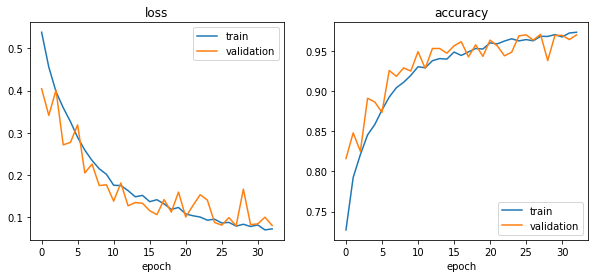

In [18]:
# print loss & accuracy and diagnosing curves
def evaluate_lstm():
    # evaluate and print scores
    scores = lstm_model.evaluate(X_val, y_val, verbose=1)
    print('\n======== Evaluation Scores ========')
    print('Validation loss: {:.4f}%'.format(scores[0] * 100))
    print('Validation accuracy: {:.4f}%'.format(scores[1] * 100))
    
    # plot diagnosing curves
    metric_list = ['loss', 'accuracy']
    
    plt.figure(figsize=(10, 4))
    
    for i, metric in enumerate(metric_list):
        plt.subplot(1, 2, i+1)
        plt.plot(lstm_history.epoch, lstm_history.history[metric], label='train')
        plt.plot(lstm_history.epoch, lstm_history.history['val_'+ metric], label='validation')
        plt.legend(loc='best')
        plt.title(metric)
        plt.xlabel('epoch')
    plt.show()
    
evaluate_lstm()

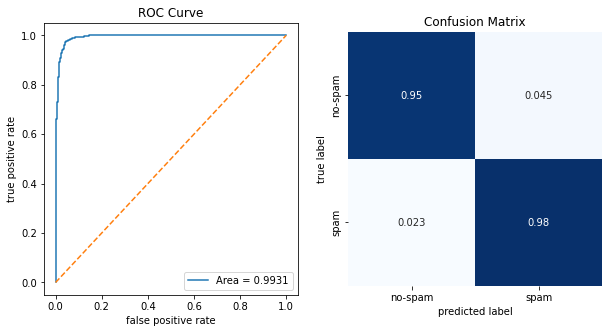

In [19]:
# more plots for model evaluation
def plot_counfusion_roc_curve():
    from sklearn.metrics import roc_curve, auc
    from sklearn.metrics import confusion_matrix
    from seaborn import heatmap
    
    # make predictions and convert probabilities & true labels into class labels
    probab = lstm_model.predict(X_test)
    y_true = np.argmax(y_test, axis=1)
    y_pred_roc = probab[:, 1] # predictions for ROC curve
    y_pred_mat = np.argmax(probab, axis=1) # predictions for matrix
    
    fig = plt.figure(figsize=(10, 5))
    
    # 1. plot ROC curve
    plt.subplot(1, 2, 1)
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_roc)
    plt.plot(fpr, tpr, label='Area = {:.4f}'.format(auc(fpr, tpr)))
    plt.plot([0,1], [0, 1], linestyle='--')
    plt.xlabel('false positive rate')
    plt.ylabel('true positive rate')
    plt.title('ROC Curve', size=12)
    plt.legend(loc='lower right')
    
    # 2. plot confusion matrix
    # heatmap properties
    hm_kwargs = dict(cmap='Blues', square=True, annot=True, cbar=False,
                     xticklabels=['no-spam', 'spam'], yticklabels=['no-spam', 'spam'])
    
    plt.subplot(1, 2, 2)
    heatmap(confusion_matrix(y_true, y_pred_mat, normalize='true'), **hm_kwargs)
    plt.xlabel('predicted label')
    plt.ylabel('true label')
    plt.title('Confusion Matrix', size=12)
    plt.show()
    
plot_counfusion_roc_curve()

### 6. Conclusions

The notebook aimed to perform and demonstrate a binary classification problem - spam detection, on a dataset of Polish emails. To complete the task we developed a LSTM model which is a specific type of recurrent neural network (RNN). We proved the high effectiveness of its application for natural language processing (NLP) tasks and achieved an overall 97.06% accuracy. Before training the neural network we used word2vec technique to convert descriptions into embeddings with a pre-trained model specifically for Polish, developed by the Polish Academy of Science. The evaluation of the neural network was done with standard plots.

Another possible method to perform this task is to use word lemmatization and a TF-IDF vectorizer. This approach uses more conventional classifiers defined with the <code>scikit-learn</code> library (logistic regression, kNN, XGBoost, etc.).

**References:**

* Aurelien Géron, 2019, *Hands-On Machine Learning with Scikit-Learn, Keras, and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems, 2nd Edition*
* http://dsmodels.nlp.ipipan.waw.pl/ [Accessed: 06.09.2023]
* https://ermlab.com/blog/technicznie/ewaluacja-polskich-word-embeddingow/ [Accessed: 06.09.2023]
* https://www.analyticsvidhya.com/blog/2021/06/lstm-for-text-classification/ [Accessed: 06.09.2023]